c:\Users\lunav\Desktop\Explain\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu
    Numéro d'application Date d'application  Numero de publication  \
83              20214575         2020-12-16                3869419   
53              17206354         2017-12-11                3342604   
70              21193803         2021-08-30                3962108   
45              18209991         2018-12-04                3502325   
44              20178596         2020-06-05                3919016   

   date de publication                                                CPC  \
83          2021-08-25             ['G06N5-01', 'G06N3-047', 'G06N3-044']   
53          2018-07-04                         ['C08L7-00', 'B60C1-0016']   
70          2022-03-02        ['H04R7-045', 'H04R2440-05', 'H04R2499-15']   
45          2019-06-26              ['C25D7-04', 'D01H7-602', 'C25D3-04']   
44          2021-12-08  ['A61B18-203', 'A61B2018-1807', 'A61B2018-0002...   

                                       IPC  \
83  ['G06N5-00', 'G06N10-00', 'G06Q10-04']   
53                ['

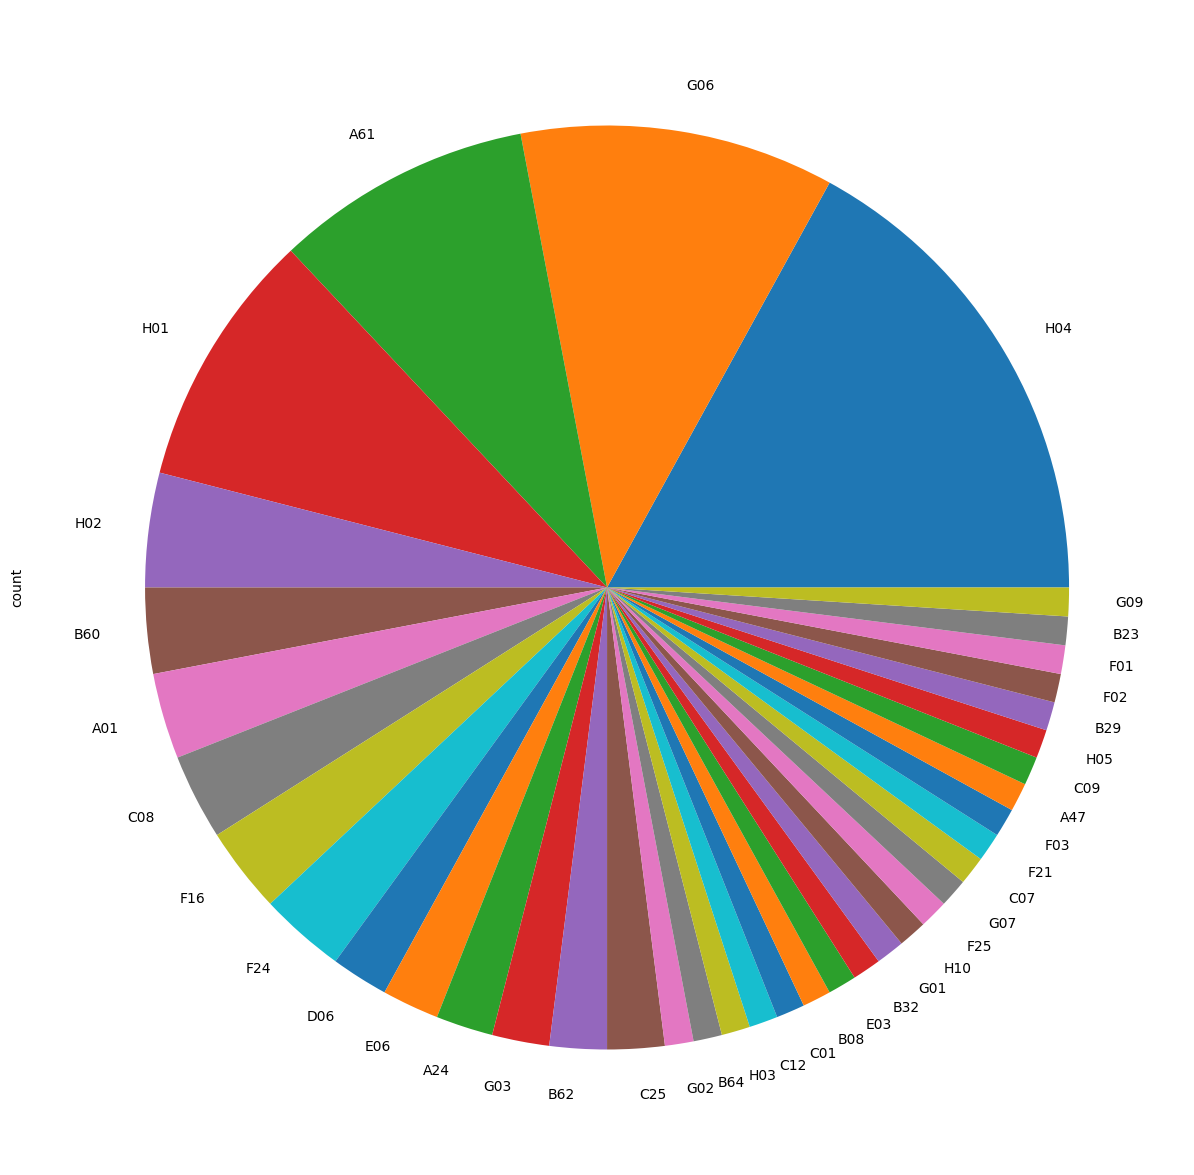

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


50 25 25


c:\Users\lunav\Desktop\Explain\.venv\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
100%|██████████| 12/12 [07:49<00:00, 39.10s/it]


{'train_runtime': 469.1621, 'train_samples_per_second': 0.32, 'train_steps_per_second': 0.026, 'train_loss': 3.729437510172526, 'epoch': 3.0}


In [1]:
import re
from matplotlib import pyplot as plt
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizer
from torch.utils.data import Dataset
from torch import cuda
import ast
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import DistilBertForSequenceClassification, BertTokenizerFast

device = 'cuda' if cuda.is_available() else 'cpu'
print(device)


df_org = pd.read_csv('EPO.csv', nrows=100)
df_org = df_org.sample(frac=1.0, random_state=42)
print(df_org.head())

#Fonction pour nettoyer le texte
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Enlever les balises HTML
    text = text.lower()  # Convertir en minuscules
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Enlever les caractères spéciaux
    return text


#Vérifier la présence des colonnes nécessaires
required_columns = ['claim', 'CPC']
for column in required_columns:
    if column not in df_org.columns:
        raise ValueError(f"La colonne '{column}' est absente du DataFrame.")

if 'IPC' in df_org.columns:
    df_org.drop(columns=['IPC'], inplace=True)
    print("La colonne 'IPC' a été supprimée avec succès.")
else:
    print("La colonne 'IPC' n'existe pas dans le DataFrame.")

if 'description' in df_org.columns:
    df_org.drop(columns=['description'], inplace=True)
    print("La colonne 'description' a été supprimée avec succès.")
else:
    print("La colonne 'description' n'existe pas dans le DataFrame.")

df_org['claim'] = df_org['claim'].apply(clean_text)


print(df_org['CPC'].head())

df_org['CPC'] = df_org['CPC'].apply(lambda x: ast.literal_eval(x)[0][:3])

labels = df_org['CPC'].unique().tolist()
labels = [s.strip() for s in labels]
print(labels)

for key, value in enumerate(labels):
    print (value)

NUM_LABELS = len(labels)
id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}
#print(label2id)
#print(id2label)

df_org['labels'] = df_org.CPC.map(lambda x: label2id[x.strip()])
print(df_org.columns)

df_org.CPC.value_counts().plot(kind = 'pie', figsize = (15, 15))
plt.show()

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", max_length=512)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

SIZE = df_org.shape[0]
train_texts = list(df_org.claim[:SIZE//2])
val_texts = list(df_org.claim[SIZE//2:(3*SIZE)//4])
test_texts = list(df_org.claim[(3*SIZE)//4:])
train_labels = list(df_org.labels[:SIZE//2])
val_labels = list(df_org.labels[SIZE//2:(3*SIZE)//4])
test_labels = list(df_org.labels[(3*SIZE)//4:])

print(len(train_texts), len(val_texts), len(test_texts))

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataloader = DataLoader(train_encodings, train_labels)
val_dataloader = DataLoader(val_encodings, val_labels)
test_dataloader = DataLoader(test_encodings, test_labels)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir = './results',          # output directory
    do_train = True,
    do_eval = True,
    num_train_epochs = 3,              # total number of training epochs
    per_device_train_batch_size = 16,  # batch size per device during training
    per_device_eval_batch_size = 32,   # batch size for evaluation
    warmup_steps = 100,                # number of warmup steps for learning rate scheduler
    weight_decay = 0.01,               # strength of weight decay
    logging_strategy='steps',
    logging_dir='./logs',
    logging_steps=50,
    evaluation_strategy='steps',
    eval_steps=50,
    save_strategy='steps',
    fp16=True,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataloader,         # training dataset
    eval_dataset=val_dataloader,             # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)

    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()

    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

model_path = 'Classification_model'
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device="cpu")

In [3]:
def process_long_text(text, tokenizer, model, max_length=512):
    # Tokenize the input text and check if it exceeds the max_length
    tokens = tokenizer.tokenize(text)
    nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device="cpu")
    if len(tokens) <= max_length:
        # If not, process it directly
        
        return nlp(text)
    else:
        # Split the text into chunks that are within the max_length
        chunks = []
        current_chunk = []
        current_length = 0
        for token in tokens:
            current_chunk.append(token)
            current_length += 1
            if current_length >= max_length:
                chunks.append(tokenizer.convert_tokens_to_string(current_chunk))
                current_chunk = []
                current_length = 0
        # Don't forget the last chunk
        if current_chunk:
            chunks.append(tokenizer.convert_tokens_to_string(current_chunk))
        
        # Process each chunk with nlp and collect results
        results = []
        for chunk in chunks:
            result = nlp(chunk)
            results.append(result)
        
        return results

# Example usage
text = "a method of configuring a water electrolysis system having at least two components wherein the first component is directly connected to the second component the method comprising the steps ofa providing a predetermined first performance curve of the first componentb providing a first degradation rate of the first componentc calculating an anticipated first performance curve of the first component for a specific timeline by modifying the predetermined first performance curve based on the first degradation rated providing a predetermined second performance curve of the second component ande configuring the second component by matching the second performance curve with the anticipated first performance curve of the first componenta method of configuring a water electrolysis system of claim 1 the method comprising the steps ofa providing a predetermined first performance curve of the first component and a predetermined second performance curve of the second componentb providing a first degradation rate of the first component and a second degradation rate of the second componentc calculating an anticipated first performance curve of the first component and an anticipated second performance curve of the second component for a specific timeline by modifying the predetermined first performance curve and the second performance curve based on the first degradation rate and the second degradation rate respectively andd optimizing the configuration of the first component and the second component by matching the anticipated first performance curve with the anticipated second performance curvethe method of configuring a water electrolysis system of claim 1 or 2 wherein the first component is a photovoltaic array and the second component is an electrolyser arrangement having at least one electrolyser stackthe method of configuring a water electrolysis system of claim lor 2 wherein the first component is an electrolyser arrangement having at least one electrolyser stack and the second component is a photovoltaic arraythe method of configuring a water electrolysis system of claim 1 or 2 wherein the specific timeline considered for calculating the anticipated first performance curve is any time between the start of life and end of life of the first component the method of configuring a water electrolysis system of claim 1 or 2 wherein the second performance curve is calculated for an end of life performance of the second componentthe method of configuring a water electrolysis system of claim 3 wherein the anticipated performance curve of the photovoltaic array is calculated by decreasing the current output values at a specific voltage in proportional to the degradation rate of the photovoltaic array with aging"
  
processed_results = process_long_text(text, tokenizer, model)
print("résultat du texte abrégé: ", processed_results)

#cpc = c25

résultat du texte abrégé:  [{'label': 'G06', 'score': 0.04010796546936035}]
